<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA6_Phase1/blob/main/EVA6_S5_F3_Third_Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- **3.	Further Modified Model**
File Name : EVA6_S5_F3_Third Iteration.ipynb
- **Target**
  - Modified LR to 0.025
  - Modified momentum to 0.8
  - Used step_lr with reduction by 0.1 for evary 6 epochs
  - Removed additional FC layer
- **Results:**
  -	Parameters: 9,680
  -	Best Test Accuracy: 99.41
  - Model was able to achieve ~ 99.4% accuracy twice and was hovering around 99.30% throughout
- **Analysis:**
  - Fine-tuning LR & momentum helped on intermittent epochs helped to avoid plateaus while training
  - Will require further fine-tuning in model to achieve 99.4% stably throughout epochs




In [1]:
!nvidia-smi

Fri Jun  4 17:07:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                       transforms.RandomRotation((-7,7),fill=(1,)),                                       
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model


In [7]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 28x28x1 , out = 26x26x16, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 26x26x16 , out = 24x24x16, RF = 5
 
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # in = 24x24x16 , out = 12x12x16, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 12x12x16 , out = 10x10x16, RF = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 10x10x16 , out = 8x8x16, RF = 14

        # OUTPUT BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 8x8x16 , out = 6x6x16, RF = 18
        self.Gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # in = 6x6x16 , out = 1x1x16, RF = 28	
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 1x1x16 , out = 1x1x10, RF = 28

    def forward(self, x):
        x = self.convblock2(self.convblock1(x))
        x = self.pool1(x)
        x = self.convblock4(self.convblock3(x))
        x = self.Gap1(self.convblock5(x))
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,304
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

# Training and Testing



In [9]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    # in view() method the shape of the desired output tensor is to be passed in as the parameter,
    # whereas in view_as() a tensor whose shape is to be mimicked it passed.
    # tensor.view_as(other) is equivalent to tensor.view(other.size())
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    if batch_idx == 468:
      train_acc_epoch.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [12]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_acc_epoch = []

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.8)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.0720507949590683 Batch_id=468 Train Accuracy=90.62: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0652, Test Accuracy: 9828/10000 (98.28%)

EPOCH: 1


Loss=0.03042999841272831 Batch_id=468 Train Accuracy=97.95: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Test Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.03402799367904663 Batch_id=468 Train Accuracy=98.32: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Test Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.06244635209441185 Batch_id=468 Train Accuracy=98.51: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Test Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.02633620984852314 Batch_id=468 Train Accuracy=98.65: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Test Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.03137250617146492 Batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.08449364453554153 Batch_id=468 Train Accuracy=98.85: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Test Accuracy: 9875/10000 (98.75%)

EPOCH: 7


Loss=0.02760363556444645 Batch_id=468 Train Accuracy=98.95: 100%|██████████| 469/469 [00:25<00:00, 18.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.029551886022090912 Batch_id=468 Train Accuracy=98.97: 100%|██████████| 469/469 [00:25<00:00, 18.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Test Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.030744224786758423 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.008422516286373138 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:25<00:00, 18.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.02295784465968609 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.09622299671173096 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 13


Loss=0.010740109719336033 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.016035588458180428 Batch_id=468 Train Accuracy=99.15: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]



Test set: Average loss: 0.0206, Test Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Test Accuracy')

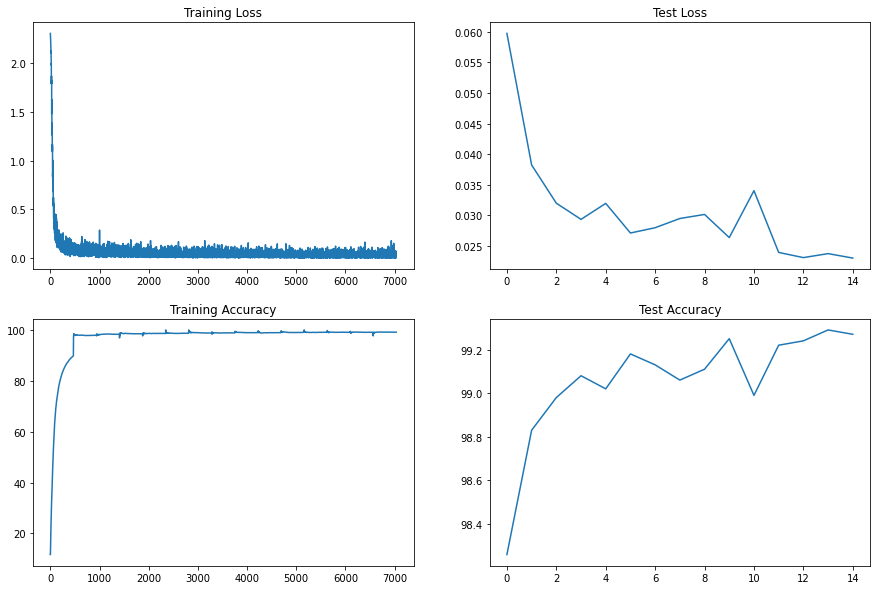

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")